# Model Training (BERT → RoBERTa Evolution)

In this notebook, I fine‑tune transformer models on my dataset. I start with **BERT‑base**, then **RoBERTa‑base**, comparing validation performance to select a final model. I also prepare for class imbalance handling and logging.


In [1]:
# move up one level so that works
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("new cwd:", os.getcwd())


new cwd: c:\Testing\Final_Year_Project\AI-Text-Detection-Tool


In [2]:
import torch
import numpy as np
import logging
import yaml
import pandas as pd
from transformers import TrainingArguments, EarlyStoppingCallback
from utils import model_utils

# Load configuration
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load splits
train_df = pd.read_parquet(config['paths']['train_data'])
val_df   = pd.read_parquet(config['paths']['val_data'])
test_df  = pd.read_parquet(config['paths']['test_data'])
print(f"Data sizes → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Set up logging to file
logging.basicConfig(
    filename=config['paths']['log_file'],
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s"
)
logging.info("Started training pipeline (BERT → RoBERTa)")

# Compute class weights for loss
labels, counts = np.unique(train_df['label'], return_counts=True)
class_weights = (1.0 / counts) * np.mean(counts)
# Map to [0,1,2] order
weight_list = [0]*len(class_weights)
for lab, wt in zip(labels, class_weights):
    idx = config['model']['label_mapping'][lab]
    weight_list[idx] = float(wt)
print("Class weights:", weight_list)


Data sizes → Train: 309520, Val: 38690, Test: 38691
Class weights: [1.0000032308194327, 1.0000032308194327, 0.999993538423763]


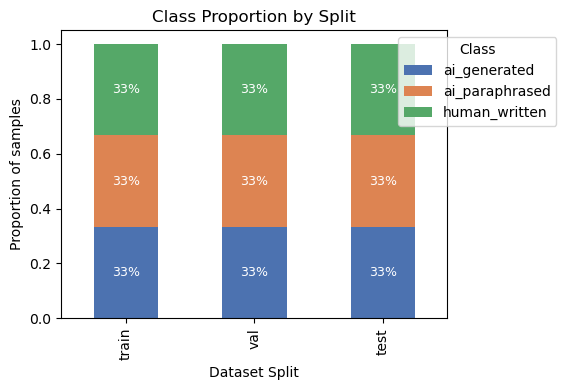

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Visualize class breakdown per split as a stacked bar chart
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# build count table
split_counts = pd.DataFrame({
    'train': train_df['label'].value_counts(normalize=True),
    'val':   val_df  ['label'].value_counts(normalize=True),
    'test':  test_df ['label'].value_counts(normalize=True),
})

# transpose so splits are on the x‐axis
split_counts = split_counts.T

# choose a simple color palette (you can tweak hex codes as you like)
colors = ['#4c72b0', '#dd8452', '#55a868']

fig, ax = plt.subplots(figsize=(6,4))
split_counts.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_title("Class Proportion by Split")
ax.set_xlabel("Dataset Split")
ax.set_ylabel("Proportion of samples")
ax.legend(title="Class", loc="upper right", bbox_to_anchor=(1.3, 1))

# annotate percentages on each bar segment
for i, split in enumerate(split_counts.index):
    cum = 0
    for j, cls in enumerate(split_counts.columns):
        val = split_counts.loc[split, cls]
        ax.text(
            i,                              # x position (bar)
            cum + val / 2,                  # y position (middle of segment)
            f"{val:.0%}",                   # label, e.g. “33%”
            ha='center', va='center',
            color='white' if val > 0.1 else 'black',
            fontsize= 9
        )
        cum += val

fig.tight_layout()
plt.show()
# optionally save:
# fig.savefig(config['paths']['figures_dir'] + "split_class_proportions.png", dpi=150)


## Fine‑tune BERT‑base

I start by fine‑tuning `bert-base-uncased` for 3 epochs (per `config.yaml`), using my `CustomTrainer` with weighted cross‑entropy or focal loss as configured.


In [4]:
# ── Device Check ────────────────────────────────────────────────────────────
import torch  # PyTorch core library

# Report whether I have CUDA (GPU) available or are falling back to CPU
if torch.cuda.is_available():
    print("🖥️  GPU available:", torch.cuda.get_device_name(0))
    print("   • CUDA devices:", torch.cuda.device_count())
    print("   • Current CUDA device index:", torch.cuda.current_device())
    # Optional: memory stats
    print(f"   • Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"   • Cached:    {torch.cuda.memory_reserved() / 1e9:.2f} GB")
else:
    print("🖥️  No GPU detected; using CPU.")


🖥️  GPU available: NVIDIA GeForce RTX 4060 Laptop GPU
   • CUDA devices: 1
   • Current CUDA device index: 0
   • Allocated: 0.00 GB
   • Cached:    0.00 GB


In [ ]:
# ── Full BERT Fine‑Tuning Pipeline (Prefer RTX 4060) ─────────────────────────

import os
import time
import logging
import yaml                          # for reading config.yaml
import psutil                        # for CPU & RAM usage
import pandas as pd                 # DataFrame I/O
import numpy as np                  # numeric ops
import torch                        # PyTorch core
from torch.utils.data import Dataset
from transformers import (
    TrainingArguments,
    EarlyStoppingCallback,
    logging as hf_logging
)
from utils import model_utils       # your wrappers around HF tokenizers/models/metrics

# ─ Silence all non‑error HF logs ─────────────────────────────────────────────
hf_logging.set_verbosity_error()

def show_resources():
    """Print current CPU%, RAM%, and (if GPU) GPU memory usage."""
    cpu_pct = psutil.cpu_percent(interval=0.5)
    ram_pct = psutil.virtual_memory().percent
    print(f"CPU: {cpu_pct:5.1f}%   RAM: {ram_pct:5.1f}%")
    if torch.cuda.is_available():
        props    = torch.cuda.get_device_properties(0)
        total_gb = props.total_memory / 1e9
        used_gb  = torch.cuda.memory_allocated(0) / 1e9
        print(f"GPU: {props.name} | Used: {used_gb:.2f} GB / {total_gb:.2f} GB")
    print("-" * 60)

# ── 1️⃣ Device selection: prefer an RTX 4060, else any CUDA GPU, else CPU ───
if torch.cuda.is_available():
    devices = [(i, torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
    # look for “RTX 4060” in any device name:
    idx_4060 = next((i for i, name in devices if "RTX 4060" in name), None)
    if idx_4060 is not None:
        device = torch.device(f"cuda:{idx_4060}")
        print(f"✔️ Using preferred GPU → {devices[idx_4060][1]} (cuda:{idx_4060})")
    else:
        # no 4060 found, pick the first GPU
        idx0, name0 = devices[0]
        device = torch.device(f"cuda:{idx0}")
        print(f"ℹ️ RTX 4060 not found, using GPU → {name0} (cuda:{idx0})")
else:
    device = torch.device("cpu")
    print("⚠️ No CUDA GPU detected — falling back to CPU")

# ── 2️⃣ Load config & data splits ─────────────────────────────────────────────
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

train_df = pd.read_parquet(config['paths']['train_data'])
val_df   = pd.read_parquet(config['paths']['val_data'])
print(f"Data sizes → train: {len(train_df)}, val: {len(val_df)}")

# ── 3️⃣ Compute class weights (for weighted CE / focal loss) ────────────────
labels, counts = np.unique(train_df['label'], return_counts=True)
inv_freq       = (1.0 / counts) * np.mean(counts)
weight_list    = [0.0] * len(inv_freq)
for lab, w in zip(labels, inv_freq):
    idx = config['model']['label_mapping'][lab]
    weight_list[idx] = float(w)
print("Class weights:", weight_list)

# ── 4️⃣ Initialize tokenizer & model, send to device ────────────────────────
tokenizer = model_utils.get_tokenizer("bert")
model     = model_utils.get_model("bert", num_labels=3).to(device)

# ── 5️⃣ Tokenize all texts (pad+truncate to max_length) ──────────────────────
max_len   = config['training']['max_length']['bert_roberta']
train_enc = tokenizer(
    train_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=max_len
)
val_enc   = tokenizer(
    val_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=max_len
)

# ── 6️⃣ Wrap tokenized data in a minimal Dataset (CPU side) ─────────────────
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_labels   = [config['model']['label_mapping'][l] for l in train_df['label']]
val_labels     = [config['model']['label_mapping'][l] for l in val_df['label']]
train_dataset  = TextDataset(train_enc, train_labels)
val_dataset    = TextDataset(val_enc,   val_labels)

# ── 7️⃣ Configure TrainingArguments ─────────────────────────────────────────
training_args = TrainingArguments(
    output_dir                  = config['paths']['model_dirs']['bert'],
    num_train_epochs            = int(config['training']['epochs']['bert']),
    per_device_train_batch_size = int(config['training']['batch_size']['bert']),
    per_device_eval_batch_size  = int(config['training']['batch_size']['bert']),
    learning_rate               = float(config['training']['learning_rate']),

    evaluation_strategy         = "epoch",
    save_strategy               = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "f1",

    logging_strategy            = "steps",
    logging_steps               = 250,
    report_to                   = "none",
    dataloader_pin_memory       = False   # avoid pin_memory errors
)

# ── 8️⃣ Instantiate CustomTrainer w/ early stopping & focal/weighted loss ──
trainer = model_utils.CustomTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = val_dataset,
    compute_metrics = model_utils.compute_metrics,
    callbacks       = [
        EarlyStoppingCallback(
            early_stopping_patience=int(config['training']['early_stopping_patience'])
        )
    ],
    use_focal       = bool(config['training']['use_focal_loss']),
    alpha           = weight_list
)

# ── 9️⃣ Run training, with resource printouts & elapsed time ────────────────
show_resources()
t0 = time.time()
print("⏳ Starting trainer.train() …")
trainer.train()
t1 = time.time()
print(f"✅ Finished in {(t1 - t0)/60:.2f} min")
show_resources()

# 🔟 Final evaluation & logging ───────────────────────────────────────────────
metrics = trainer.evaluate()
print("📝 Validation metrics:", metrics)
logging.info(f"BERT validation metrics → {metrics}")


✔️ Using preferred GPU → NVIDIA GeForce RTX 4060 Laptop GPU (cuda:0)
Data sizes → train: 309520, val: 38690
Class weights: [1.0000032308194327, 1.0000032308194327, 0.999993538423763]


c:\Users\micha\.conda\envs\myenv\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


CPU:   5.1%   RAM:  75.8%
GPU: NVIDIA GeForce RTX 4060 Laptop GPU | Used: 0.44 GB / 8.59 GB
------------------------------------------------------------
⏳ Starting trainer.train() …
{'loss': 0.5968, 'grad_norm': 10.763648986816406, 'learning_rate': 1.9913845093478074e-05, 'epoch': 0.012923235978288964}
{'loss': 0.4308, 'grad_norm': 9.543089866638184, 'learning_rate': 1.982769018695615e-05, 'epoch': 0.025846471956577927}
{'loss': 0.3916, 'grad_norm': 6.777531623840332, 'learning_rate': 1.9741535280434225e-05, 'epoch': 0.03876970793486689}
{'loss': 0.3707, 'grad_norm': 3.571722984313965, 'learning_rate': 1.9655380373912297e-05, 'epoch': 0.051692943913155855}
{'loss': 0.35, 'grad_norm': 12.810379028320312, 'learning_rate': 1.956922546739037e-05, 'epoch': 0.06461617989144482}


### BERT Validation Results

After fine‑tuning **BERT‑base**, I observe:

- **Loss:** *`<insert bert_metrics['eval_loss'] here>`*  
- **Accuracy:** *`<insert bert_metrics['eval_accuracy'] here>`*  
- **Macro‑F1:** *`<insert bert_metrics['eval_f1'] here>`*

These results provide our baseline before moving on to RoBERTa. I’ll compare these metrics directly in the next section.


## Fine‑tune RoBERTa‑base

Now I train `roberta-base` under the same conditions to see if it improves over BERT.


In [ ]:
# ── 1) Prepare RoBERTa tokenizer & model ───────────────────────────
tokenizer_roberta = model_utils.get_tokenizer("roberta")
model_roberta     = model_utils.get_model("roberta", num_labels=3).to(device)

# ── 2) (Re‑)tokenize texts for RoBERTa ─────────────────────────────
#    Note: must redo tokenization because RoBERTa's vocab & special tokens differ
train_enc_roberta = tokenizer_roberta(
    train_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=config['training']['max_length']['bert_roberta']
)
val_enc_roberta = tokenizer_roberta(
    val_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=config['training']['max_length']['bert_roberta']
)

# ── 3) Wrap into torch Datasets ────────────────────────────────────
train_dataset_roberta = TextDataset(train_enc_roberta,
                                    [config['model']['label_mapping'][l] for l in train_df['label']])
val_dataset_roberta   = TextDataset(val_enc_roberta,
                                    [config['model']['label_mapping'][l] for l in val_df['label']])

# ── 4) Update & reuse TrainingArguments ────────────────────────────
#    (point at new output dir, adjust epochs)
training_args_roberta = TrainingArguments(
    output_dir                  = config['paths']['model_dirs']['roberta'],
    num_train_epochs            = int(config['training']['epochs']['roberta']),
    per_device_train_batch_size = int(config['training']['batch_size']['roberta']),
    per_device_eval_batch_size  = int(config['training']['batch_size']['roberta']),
    learning_rate               = float(config['training']['learning_rate']),
    evaluation_strategy         = "epoch",
    save_strategy               = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "f1",
    logging_strategy            = "steps",
    logging_steps               = logging_steps,      # reuse the same logging interval
    report_to                   = "none",
    dataloader_pin_memory       = False
)

# ── 5) Instantiate CustomTrainer for RoBERTa ────────────────────────
trainer_roberta = model_utils.CustomTrainer(
    model           = model_roberta,
    args            = training_args_roberta,
    train_dataset   = train_dataset_roberta,
    eval_dataset    = val_dataset_roberta,
    compute_metrics = model_utils.compute_metrics,
    callbacks       = [EarlyStoppingCallback(
                         early_stopping_patience=int(config['training']['early_stopping_patience'])
                       )],
    use_focal       = bool(config['training']['use_focal_loss']),
    alpha           = weight_list
)

# ── 6) Train & evaluate ────────────────────────────────────────────
print("⏳ Starting RoBERTa training…")
start = time.time()
trainer_roberta.train()
elapsed = (time.time() - start) / 60
print(f"✅ RoBERTa training finished in {elapsed:.1f} min")

print("📝 Evaluating RoBERTa on validation split…")
roberta_metrics = trainer_roberta.evaluate()
print("RoBERTa Validation metrics:", roberta_metrics)
logging.info(f"RoBERTa validation metrics → {roberta_metrics}")
